In [1]:
import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.animation as animation
import matplotlib.pyplot as plt

In [2]:
# fpath = "F:\\pp1_data_processing\\2023-05-22_21-17-37 dac showing pacman.csv"
# fpath = "F:\\pp1_data_processing\\2023-05-22_22-36-06 dac showing pacman 200MHz.csv"
# fpath = "C:\\Users\\ionca\\Desktop\\pp1\\2023-05-23_17-58-21 dac 200MHz one line.csv"
fpath = "F:\\pp1_data_processing\\2023-05-24_21-46-19 dac showing camera feed interlaced 200MHz.csv"
df = pd.read_csv(fpath)

In [3]:
# get all the falling edges of !vid_conv where the dac data is latched
conv_diffs = df[' !VID_CONV'].diff()
dacdf = df.loc[conv_diffs == -1].copy()
dacdf.reset_index(inplace=True, drop=True)
dacdf.drop(columns=' !VID_CONV', inplace=True)
dacdf

Time[s]   DAC0   DAC1   DAC2   DAC3   DAC4   DAC5   DAC6   
0         6.500000e-08      0      0      1      0      1      1      0  \
1         1.350000e-07      1      0      1      0      1      1      0   
2         2.050000e-07      1      0      1      0      1      1      0   
3         2.750000e-07      1      1      0      0      1      1      0   
4         3.450000e-07      0      0      1      0      1      1      0   
...                ...    ...    ...    ...    ...    ...    ...    ...   
17559344  1.226380e+00      0      0      0      1      1      1      0   
17559345  1.226380e+00      0      0      0      1      1      1      0   
17559346  1.226380e+00      0      0      0      1      1      1      0   
17559347  1.226381e+00      1      0      1      0      1      1      0   
17559348  1.226381e+00      0      1      1      0      1      1      0   

           DAC7   VID_BLK  
0             0         0  
1             0         0  
2             0         0  
3             0         0  
4             0         0  
...         ...       ...  
17559344      0         0  
17559345      0         0  
17559346      0         0  
17559347      0         0  
17559348      0         0  

[17559349 rows x 10 columns]

In [4]:
vidblk_arr = dacdf[' VID_BLK'].to_numpy()
_,pk_prop = signal.find_peaks(vidblk_arr, plateau_size=[1])
pk_prop

{'plateau_sizes': array([67, 67, 67, ..., 67, 66, 67], dtype=int64),
 'left_edges': array([     151,     1061,     1971, ..., 17556781, 17557691, 17558601],
       dtype=int64),
 'right_edges': array([     217,     1127,     2037, ..., 17556847, 17557756, 17558667],
       dtype=int64)}

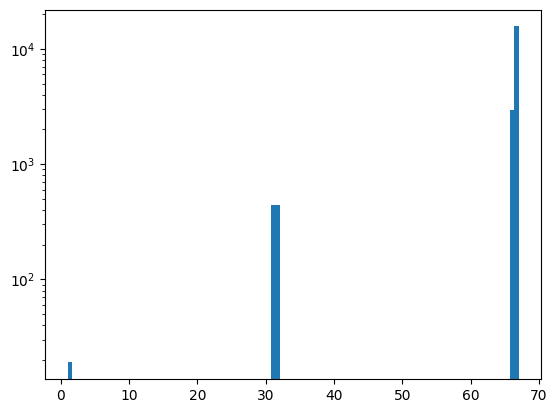

In [5]:
plt.hist(pk_prop['plateau_sizes'][pk_prop['plateau_sizes']<100], bins=100)
plt.yscale('log')
plt.show()

In [6]:
# remove glitches in the vidblk signal
for start,end in zip(pk_prop['left_edges'][pk_prop['plateau_sizes'] < 20], pk_prop['right_edges'][pk_prop['plateau_sizes'] < 20]):
    dacdf.loc[start:end, ' VID_BLK'] = 0


In [7]:
# convert binary columns to numpy
bits_arr = dacdf[[' DAC0', ' DAC1', ' DAC2', ' DAC3', ' DAC4', ' DAC5', ' DAC6', ' DAC7']].to_numpy()
# convert to decimal
decimal_arr = np.sum(bits_arr * (2**np.arange(0,8)), axis=1)
# store in new column
dacdf['VALUE'] = decimal_arr

# combine values with VID_BLK to create the video signal
dacdf['SIGNAL'] = dacdf['VALUE']
dacdf.loc[dacdf[' VID_BLK'] == 1, 'SIGNAL'] = 0
dacdf.head()

Time[s]   DAC0   DAC1   DAC2   DAC3   DAC4   DAC5   DAC6   DAC7   
0  6.500000e-08      0      0      1      0      1      1      0      0  \
1  1.350000e-07      1      0      1      0      1      1      0      0   
2  2.050000e-07      1      0      1      0      1      1      0      0   
3  2.750000e-07      1      1      0      0      1      1      0      0   
4  3.450000e-07      0      0      1      0      1      1      0      0   

    VID_BLK  VALUE  SIGNAL  
0         0     52      52  
1         0     53      53  
2         0     53      53  
3         0     51      51  
4         0     52      52

C:\Users\ionca\AppData\Local\Temp\ipykernel_29688\1620536466.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  dacdf.iloc[:1300].plot(y=['SIGNAL', ' VID_BLK'], subplots=True, ax=ax, use_index=True)


array([<Axes: >, <Axes: >], dtype=object)

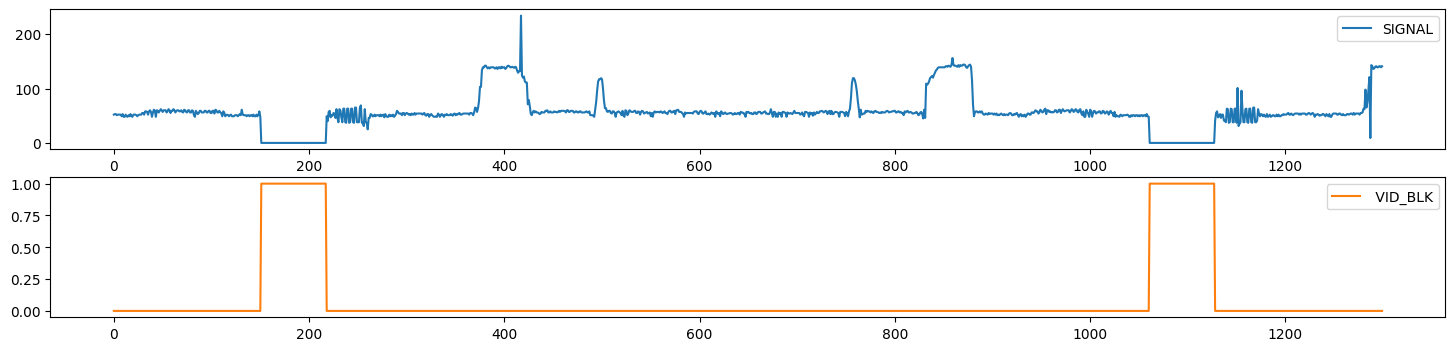

In [9]:
fig, ax = plt.subplots()
fig.set_size_inches(18, 4)
dacdf.iloc[:1300].plot(y=['SIGNAL', ' VID_BLK'], subplots=True, ax=ax, use_index=True)

timing of vid signal where falling edge of horizontal sync pulse (blanking) is t=0s  
t=-2.5650us front porch  
t=0us vidblanking  
t=4.6200us back porch  
t=5.3250us colorburst  
t=8.1250us end colorburst  
t=9.6400us begin scanline  
t=61.250us end scanline  

In [8]:
# get start and end indices of each scanline
scanline_start_indices = dacdf[dacdf[' VID_BLK'].diff() == 1].iloc[:-1].index.to_series()
scanline_end_indices = dacdf[dacdf[' VID_BLK'].diff() == 1].iloc[1:].index.to_series() - 1

# a list of dataframes that each contain a single scanline
scanlines = []
for start,end in zip(scanline_start_indices, scanline_end_indices):
    scanline = dacdf.loc[start:end, ['Time[s]', ' VID_BLK', 'VALUE', 'SIGNAL']]
    scanline['datetime'] = pd.to_datetime(scanline['Time[s]'],unit='s')
    scanlines.append(scanline)

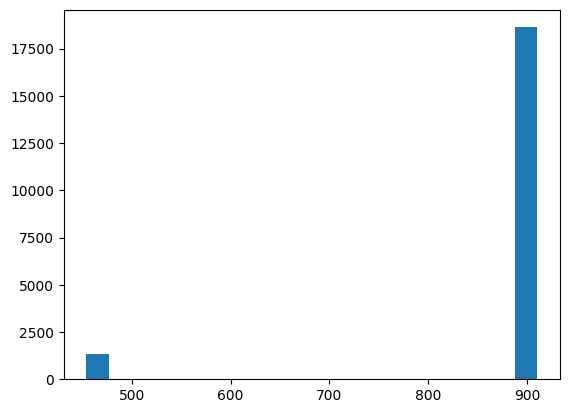

In [11]:
scanline_lengths = [x.shape[0] for x in scanlines]
plt.hist(scanline_lengths, bins=20)
plt.show()

In [12]:
scanline_lengths = np.array(scanline_lengths)

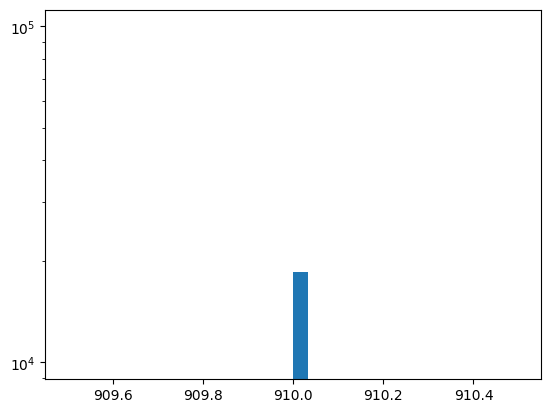

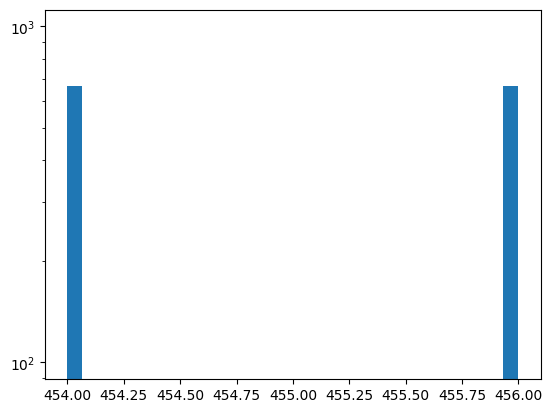

In [13]:
long_scanlines = [x for x in scanline_lengths if x > 900]
short_scanlines = [x for x in scanline_lengths if x < 900]
nbin = 30
plt.hist(long_scanlines,bins=nbin)
plt.yscale('log')
plt.show()
plt.hist(short_scanlines,bins=nbin)
plt.yscale('log')
plt.show()

In [14]:
scanline_lengths_df = pd.DataFrame(scanline_lengths)
print(scanline_lengths_df.value_counts())

910    18629
454      666
456      666
Name: count, dtype: int64


C:\Users\ionca\AppData\Local\Temp\ipykernel_29688\2666999878.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  pd.concat(scanlines[vsync-window:vsync+window]).plot(y=['SIGNAL',' VID_BLK'], subplots=True, ax=ax, use_index=True)


array([<Axes: >, <Axes: >], dtype=object)

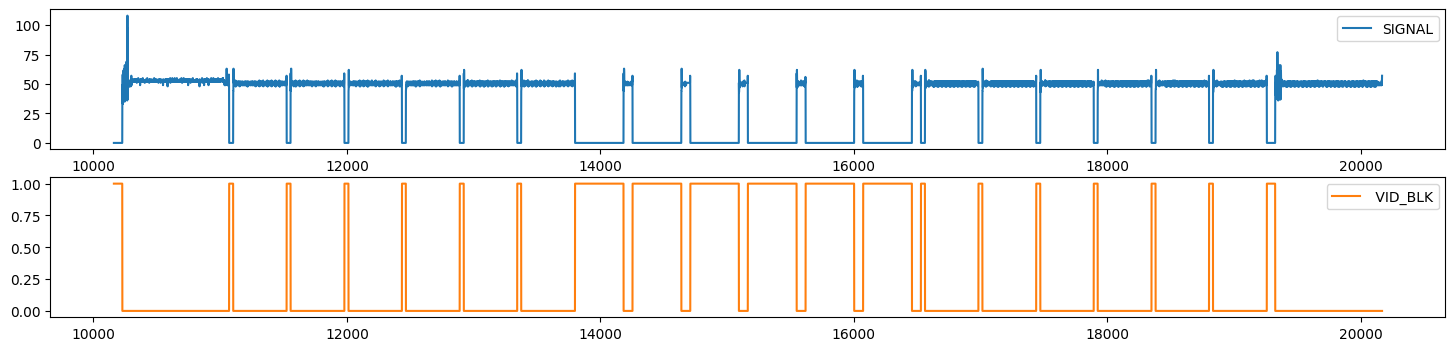

In [15]:
fig, ax = plt.subplots()
fig.set_size_inches(18, 4)
vsync = (29-12)//2 + 12 +1
window = 10
pd.concat(scanlines[vsync-window:vsync+window]).plot(y=['SIGNAL',' VID_BLK'], subplots=True, ax=ax, use_index=True)

C:\Users\ionca\AppData\Local\Temp\ipykernel_29688\2894202964.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  pd.concat(scanlines[vsync-window:vsync+window]).plot(y=['SIGNAL',' VID_BLK'], subplots=True, ax=ax, use_index=True)


array([<Axes: >, <Axes: >], dtype=object)

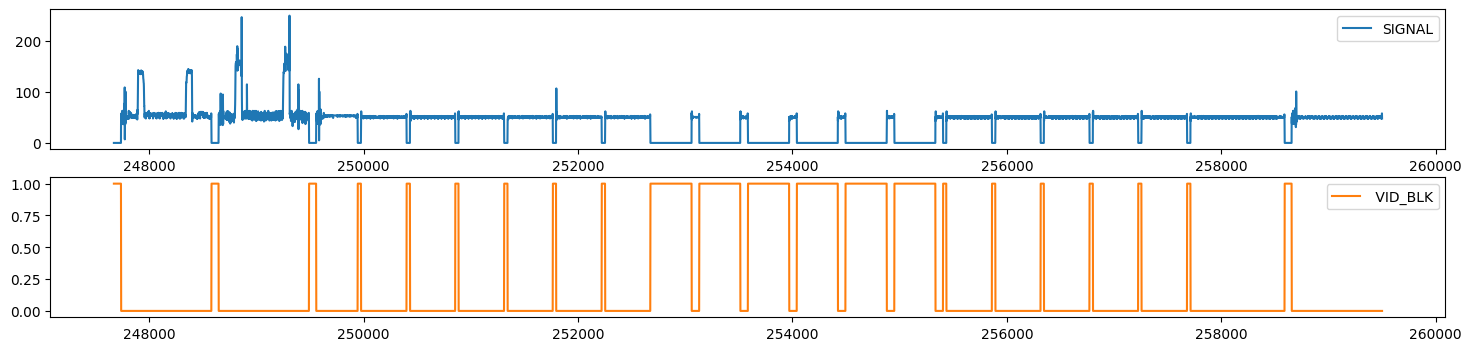

In [16]:
fig, ax = plt.subplots()
fig.set_size_inches(18, 4)
vsync = (300-283)//2 + 283 +1
window = 11
pd.concat(scanlines[vsync-window:vsync+window]).plot(y=['SIGNAL',' VID_BLK'], subplots=True, ax=ax, use_index=True)

In [17]:
print('Even field line widths')
for line in scanlines[282:289]:
    print(len(line[line[' VID_BLK'] == 0]))
print('Odd field line widths')
for line in scanlines[10:17]:
    print(len(line[line[' VID_BLK'] == 0]))


Even field line widths
843
387
425
422
425
422
425
Odd field line widths
843
843
422
425
422
425
422


In [58]:
scanlines[29]['VALUE'][220:]

19025    51
19026    52
19027    52
19028    49
19029    52
         ..
19256    53
19257    49
19258    51
19259    57
19260    49
Name: VALUE, Length: 236, dtype: int64

In [9]:
def determine_signal_states(scanlines:list, line_length_threshold=900):
    updated_scanlines = []
    _scanlines = [line.copy() for line in scanlines]
    # possible states: vsync, vsync_even, vsync_odd, even_field, odd_field, incomplete
    found_first_vsync = False
    linenumber = 0
    last_line = None
    for i in range(len(_scanlines)):
        line = _scanlines[i]
        if not found_first_vsync:
            if len(line) > line_length_threshold:
                line['STATE'] = 'incomplete'
                line['linenumber'] = -1
            else:
                found_first_vsync = True
                line['STATE'] = 'vsync'
                linenumber = 0
                line['linenumber'] = linenumber
        else:
            if len(line) > line_length_threshold: # we are not in vsync
                if 'vsync' in last_line['STATE'].iloc[0]: # we just exited vsync
                    line['STATE'] = last_line['STATE'].iloc[0].split('_')[0] + '_field'
                else: # we exited vsync a while ago
                    line['STATE'] = last_line['STATE'].iloc[0]
            else: # we are in vsync
                if 'vsync' in last_line['STATE'].iloc[0]: # we are in vsync
                    if 'vsync' == last_line['STATE'].iloc[0]: # we entered vsync on last line
                        if len(line[line[' VID_BLK'] == 0]) > len(last_line[last_line[' VID_BLK'] == 0]) \
                            and abs(len(line[line[' VID_BLK'] == 0]) - len(last_line[last_line[' VID_BLK'] == 0])) > 10: # we are in even field vsync
                                
                            line['STATE'] = 'even_vsync'
                            updated_scanlines[-1]['STATE'] = 'even_vsync'
                            updated_scanlines[-1]['linenumber'] = 0
                            linenumber = 1
                        else: # we are in odd field vsync
                            line['STATE'] = 'odd_vsync'
                            updated_scanlines[-1]['STATE'] = 'odd_vsync'
                    else: # we entered vsync a while ago
                        line['STATE'] = last_line['STATE'].iloc[0]
                else: # we just entered vsync
                    line['STATE'] = 'vsync'
            
            line['linenumber'] = linenumber
                        
        last_line = line
        updated_scanlines.append(line)
        linenumber += 1
    
    return updated_scanlines

newscanlines = determine_signal_states(scanlines)

In [19]:
print("Even Field")
print(pd.concat(newscanlines[282:289])[['STATE', 'linenumber']])
print("Odd Field")
print(pd.concat(newscanlines[10:17])[['STATE', 'linenumber']])

Even Field
             STATE  linenumber
248581   odd_field         270
248582   odd_field         270
248583   odd_field         270
248584   odd_field         270
248585   odd_field         270
...            ...         ...
252216  even_vsync           5
252217  even_vsync           5
252218  even_vsync           5
252219  even_vsync           5
252220  even_vsync           5

[3640 rows x 2 columns]
Odd Field
            STATE  linenumber
9251   incomplete          -1
9252   incomplete          -1
9253   incomplete          -1
9254   incomplete          -1
9255   incomplete          -1
...           ...         ...
13340   odd_vsync           4
13341   odd_vsync           4
13342   odd_vsync           4
13343   odd_vsync           4
13344   odd_vsync           4

[4094 rows x 2 columns]


In [10]:
fieldsdf = pd.concat(newscanlines)
fieldsdf = fieldsdf[fieldsdf['STATE'] != 'incomplete'] # drop incompletes
# encode states into a sequence [0,1,2,3] (even_vsync, even_field, odd_vsync, odd_field)
fieldsdf.loc[fieldsdf['STATE']=='even_vsync','statenum'] = 0
fieldsdf.loc[fieldsdf['STATE']=='even_field','statenum'] = 1
fieldsdf.loc[fieldsdf['STATE']=='odd_vsync','statenum'] = 2
fieldsdf.loc[fieldsdf['STATE']=='odd_field','statenum'] = 3
# get index of start of first even sync
start_first_even_sync = fieldsdf['statenum'].eq(0).idxmax()
# drop all rows before it
fieldsdf = fieldsdf.loc[start_first_even_sync:]
# get index of end of last odd field
end_last_odd_field = fieldsdf['statenum'].sort_index(ascending=False).eq(3).idxmax()
# drop all rows after it
fieldsdf = fieldsdf.loc[:end_last_odd_field]

In [617]:
from scipy.optimize import leastsq, least_squares
frame_start_indices = fieldsdf[fieldsdf['statenum'].diff().eq(-3.0)].index.to_numpy()
frame_end_indices = frame_start_indices.copy() - 1
frame_start_indices = frame_start_indices.tolist()
frame_start_indices.insert(0,0)
frame_end_indices = frame_end_indices.tolist()
frame_end_indices.append(fieldsdf.index.max())

n_frames = len(frame_end_indices)

# create a numpy ndarray containing frames
frames_arr = np.ndarray((n_frames, 525, 910, 3)) # n_frames images, each is 525x910px and has 3 color channels

croptop,cropbottom = 23,506
cropleft,cropright = 50,780

# ideal_carrier_params = [7, 3.579545e6, 0.0, 50] # amplitude, freq[Hz], phase[rad], mean
ideal_carrier_params = [3.579545e6, 0.0]
line_info = []

cbursts = []

freq_avg_len = 100
freq_running_avg = []
def update_freq(f : int = None):
    if f:
        freq_running_avg.insert(0,f)
        if len(freq_running_avg) > freq_avg_len:
            freq_running_avg.pop()
    return np.mean(freq_running_avg)
phase_avg_len = 100
phase_running_avg = []
def update_phase(f : int = None):
    if f:
        phase_running_avg.insert(0,f)
        if len(phase_running_avg) > phase_avg_len:
            phase_running_avg.pop()
    return np.mean(phase_running_avg)
     

# extract luma info from all fields and store in frames
i = 0
for start, end in zip(frame_start_indices, frame_end_indices):
    # select the current frame's data
    only_fields = fieldsdf.loc[start:end] 
    # discard vsyncs
    only_fields = only_fields.loc[(only_fields['STATE'] == 'even_field') | (only_fields['STATE'] == 'odd_field')]
    # create new linenumbers that count hsync pulses
    only_fields['linenumber'] = (only_fields[' VID_BLK'].diff() < 0).cumsum()
    y = 0
    state = 'even'
    grouped = only_fields[['linenumber', 'datetime', 'STATE','SIGNAL']].groupby('linenumber')
    for lineno, linegroupdf in grouped:
        line_timedelta = linegroupdf.datetime.max() - linegroupdf.datetime.min()
        ##### BW ONLY
        # line_timedelta /= 6
        if line_timedelta.total_seconds() > 60e-6:
            # calculate subcarrier frequency
            cburst = linegroupdf.iloc[:50]
            cburstcpy = cburst.copy(deep=True)
            cbursts.append(cburstcpy.copy(deep=True))
            ##### using fft's to determine phase, freq
            # n = len(cburst['SIGNAL'])
            # k = np.arange(n)
            # # Fs = 14.2857143e6 # Hz, sample frequency taken from !VID_CONV signal in original DF
            # # Fs = 13.5e6 # Hz, taken from videonics website
            # # calculate average frequency during cburst
            # Fs = 1e6 / np.diff(cburst['datetime'].to_numpy()).astype(np.float64).mean()
            # T = n/Fs
            # frequencies = k/T
            # frequencies = frequencies[:len(frequencies)//2]
            # CBURST = np.fft.fft(cburst['SIGNAL'])/n
            # CBURST = CBURST[:n//2]
            # peaks,props = signal.find_peaks(abs(CBURST), height=0)
            # # remove peak frequencies outside of 3-4MHz
            # peak_nums = np.arange(len(peaks))
            # peak_freqs = frequencies[peaks]
            # peak_nums = peak_nums[(peak_freqs < 4e6) & (peak_freqs > 3e6)]
            
            # if len(peak_nums) > 0:
            #     peaks = peaks[peak_nums]
            #     props['peak_heights'] = props['peak_heights'][peak_nums]
            #     cburst_freq = frequencies[peaks[props['peak_heights'].argmax()]]
            # else:
            #     cburst_freq = pd.NA
            #     print(f'No peaks within 3-4 MHz on {linegroupdf.index.min()}:{linegroupdf.index.max()} @ {lineno}' )
            
            #### Using the least squares optimization from numpy to find subcarrier
            cburst = cburst['SIGNAL'].to_numpy()
            t_cburst = linegroupdf.iloc[:50]['datetime'].to_numpy().astype(np.float64) * 1e-9 # seconds
            
            t_scanline = linegroupdf.iloc[51:]['datetime'].to_numpy().astype(np.float64) * 1e-9 # seconds
            scanline = linegroupdf.iloc[51:]
            scanline = scanline.iloc[:-70] # crop out hsync (roughly)
            t_scanline = scanline['datetime'].to_numpy(np.float64) * 1e-9 # seconds
            scanline = scanline['SIGNAL'].to_numpy()
            # scanline = scanline.loc[scanline['SIGNAL'] > 1] # crop the hsync out of the scanline
            
            # calculate average sampling frequency during the the entire signal
            # Fs =(1 / np.diff(np.concatenate([t_cburst, t_scanline]))).mean()
            Fs =(1 / np.diff(t_cburst)).mean()
            
            # use least squares to determine best params
            # optimize_func = lambda x: x[0]*np.sin(2*np.pi*x[1]*t_cburst + x[2]) + x[3] - cburst
            # optimize_func = lambda x: (x[0]*np.sin(2*np.pi*x[1]*t_cburst + x[2]) + x[3] - cburst)*16 # accuracy tweaks
            # est_amp, est_freq, est_phase, est_mean = leastsq(optimize_func, ideal_carrier_params)[0]
            # est_amp, est_freq, est_phase, est_mean = least_squares(optimize_func, 
            #                                                        ideal_carrier_params,
            #                                                        bounds=([0,3e6,0,0],[20,4e6,2*np.pi,255]),
            #                                                        method='trf')['x'] # try dogbox, lm, trf
            black_level = cburst.mean()
            # normalize cburst between -1 and 1
            cburst = 2*(cburst-cburst.min())/cburst.ptp() - 1
            # remove dc offset
            cburst = cburst - cburst.mean()
            # clip to half amplitude (hopefully removing amplitude spikes)
            cburst = np.clip(cburst, -0.2, 0.2)
            # again, normalize cburst between -1 and 1
            cburst = 2*(cburst-cburst.min())/cburst.ptp() - 1
            # again, remove dc offset
            cburst = cburst - cburst.mean()
            
            # optimize using simplified param list
            optimize_func = lambda x: np.sin(2*np.pi*x[0]*t_cburst + x[1]) - cburst
            est_freq, est_phase = leastsq(optimize_func, ideal_carrier_params, ftol=1.0e-11, xtol=1.0e-11)[0]
            
            # perform running averages of phase and freq
            # est_freq = update_freq(est_freq)
            # est_phase = update_phase(est_phase)
            
            # ideal_carrier_params = [est_amp, est_freq, est_phase, est_mean] # update guesses for next time
            # ideal_carrier_params = [est_freq, est_phase] # update guesses for next time
            cburst_freq = est_freq
            cburst_phase = est_phase
            
            # use params to produce a signal that spans the scanline portion
            est_amp = 1.0
            carrier_fit_sin = est_amp * np.sin(2*np.pi*est_freq*t_scanline + est_phase) #+ est_mean
            carrier_fit_cos = est_amp * np.cos(2*np.pi*est_freq*t_scanline + est_phase) #+ est_mean
            # carrier_fit_cos = est_amp * np.sin(2*np.pi*est_freq*t_scanline + est_phase - np.pi/2) # using a diff phase shift
            # calculate sample length of 2 periods of the carrier, for length of moving average filter
            samples_per_carrier_cycle = int(0.5 + Fs / est_freq)
            # samples_per_carrier_cycle = int(0.5 + 14.3e6 / 3.7e6)
            mov_avg_len = 2*samples_per_carrier_cycle
            # extract Y I Q
            Y = scanline  # normalize?
            Y = (Y-Y.min())/Y.ptp()
            I = 4 * Y * carrier_fit_sin
            Q = 4 * Y * carrier_fit_cos
            # apply moving average filters
            kernel = np.ones(mov_avg_len)
            # Y_avg = np.convolve(Y, kernel[:mov_avg_len//2], 'same') / (mov_avg_len//2)
            I_avg = np.convolve(I, kernel, 'same') / mov_avg_len
            Q_avg = np.convolve(Q, kernel, 'same') / mov_avg_len
            Y_avg = Y
            I_avg = I
            Q_avg = Q
        else:
            cburst_freq = pd.NA
            cburst_phase = pd.NA
        # # log some data
        line_info.append([line_timedelta, lineno, start, end, cburst_freq, cburst_phase])
        
        # switch to odd field when done with even field
        if state=='even' and linegroupdf['STATE'].iloc[0] == 'odd_field':
            y = 1
            state = 'odd'
            
        if line_timedelta.total_seconds() > 60e-6:
            # colorspace conversion
            # https://en.wikipedia.org/wiki/YIQ
            YIQ_norm = np.array([
                            (Y_avg-Y_avg.min())/Y_avg.ptp(), # normalize to [0, 1]
                            (2*(I_avg-I_avg.min())/I_avg.ptp()-1.0)*0.5957, # normalize to [-0.5957, 0.5957]
                            (2*(Q_avg-Q_avg.min())/Q_avg.ptp()-1.0)*0.5226 # normalize to [-0.5226, 0.5226]
                        ])
            # using FCC NTSC Standard (SMPTE C) circa 1987
            yiq_2_rgb_smpte = np.array([[1.0, 0.9469, 0.6236],
                                 [1.0, -0.2748, -0.6357],
                                 [1.0, -1.1, 1.7]])
            # yiq_2_rgb_1953 = np.array([[1.0, 0.956, 0.619],
            #                      [1.0, -0.272, -0.647],
            #                      [1.0, -1.106, 1.703]])
            RGB = yiq_2_rgb_smpte @ YIQ_norm # matrix multiplication
            # RGB = yiq_2_rgb_1953 @ YIQ_norm
            
            # RGB[0,:] = 255*(RGB[0,:]-RGB[0,:].min())/RGB[0,:].ptp() # normalize to [0,255]
            # RGB[1,:] = 255*(RGB[1,:]-RGB[1,:].min())/RGB[1,:].ptp() # normalize to [0,255]
            # RGB[2,:] = 255*(RGB[2,:]-RGB[2,:].min())/RGB[2,:].ptp() # normalize to [0,255]
            # RGB = 255*(RGB-RGB.min())/RGB.ptp()
            # # # round to uint8
            # RGB = np.rint(RGB).astype(np.uint8)
            
            
            linelen = RGB.shape[1]
            frames_arr[i, y, :linelen, :] = RGB.T
        else:
            linelen = len(linegroupdf[linegroupdf['SIGNAL']>0])
            # just luma here
            luma = linegroupdf[linegroupdf['SIGNAL']>0]['SIGNAL'].to_numpy(np.uint8)
            frames_arr[i, y, :linelen, 0] = luma
            frames_arr[i, y, :linelen, 1] = luma
            frames_arr[i, y, :linelen, 2] = luma
                
        y += 2
    frames_arr[i] = np.clip(frames_arr[i], 0, 1)
    # normalize the frame's RBB levels
    frames_arr[i,croptop:cropbottom, cropleft:cropright, :] = (255*(frames_arr[i,croptop:cropbottom, cropleft:cropright, :]\
                                                                -frames_arr[i,croptop:cropbottom, cropleft:cropright, :].min())\
                                                                /frames_arr[i,croptop:cropbottom, cropleft:cropright, :].ptp())
    frames_arr[i] = np.rint(frames_arr[i]).astype(np.uint8)
    i+=1
frames_arr = frames_arr.astype(np.uint8)

c:\Users\ionca\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_minpack_py.py:492: RuntimeWarning: xtol=0.000000 is too small, no further improvement in the approximate
  solution is possible.
  warnings.warn(errors[info][0], RuntimeWarning)
c:\Users\ionca\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_minpack_py.py:492: RuntimeWarning: Number of calls to function has reached maxfev = 600.
  warnings.warn(errors[info][0], RuntimeWarning)
c:\Users\ionca\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_minpack_py.py:492: RuntimeWarning: xtol=0.000000 is too small, no further improvement in the approximate
  solution is possible.
  warnings.warn(errors[info][0], RuntimeWarning)
c:\Users\ionca\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_minpack_py.py:492: RuntimeWarning: xtol=0.000000 is too small, no further improvement in the approximate
  solution is possible.
  warnings.warn(error

In [387]:
for c in cbursts:
    c['time'] = c['datetime'].diff().cumsum()
    x = c['time'].to_numpy().astype(np.float64) * 1e-9
    x[0] = 0.0
    c['time'] = x


In [388]:
cbursts_numpy = np.concatenate([x[['time', 'SIGNAL']].to_numpy() for x in cbursts])
cbursts_numpy.shape

(910800, 2)

In [391]:
cbursts_numpy[:10, 0]

array([0.0e+00, 7.0e-08, 1.4e-07, 2.1e-07, 2.8e-07, 3.5e-07, 4.2e-07,
       4.9e-07, 5.6e-07, 6.3e-07])

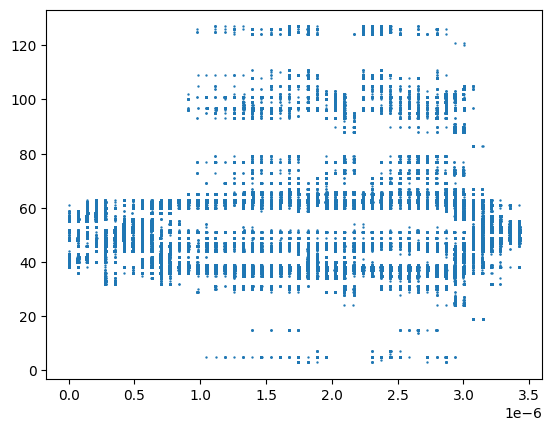

In [393]:
plt.scatter(x=cbursts_numpy[:,0], y=cbursts_numpy[:,1], s=0.5)
plt.show()

In [265]:
YIQ_norm = np.array([
                            (Y_avg-Y_avg.min())/Y_avg.ptp(), # normalize to [0, 1]
                            (2*(I_avg-I_avg.min())/I_avg.ptp()-1.0)*0.5957, # normalize to [-0.5957, 0.5957]
                            (2*(Q_avg-Q_avg.min())/Q_avg.ptp()-1.0)*0.5226 # normalize to [-0.5226, 0.5226]
                        ])
# using FCC NTSC Standard (SMPTE C) circa 1987
yiq_2_rgb_smpte = np.array([[1.0, 0.9469, 0.6236],
                        [1.0, -0.2748, -0.6357],
                        [1.0, -1.1, 1.7]])
(yiq_2_rgb_smpte @ YIQ_norm)[0,:].min()
# YIQ_norm[1,:].max()

-0.88996169

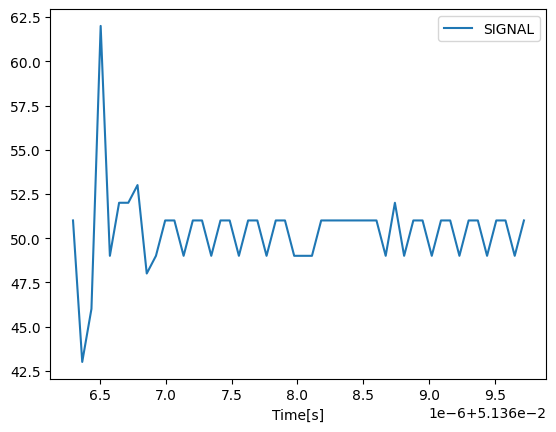

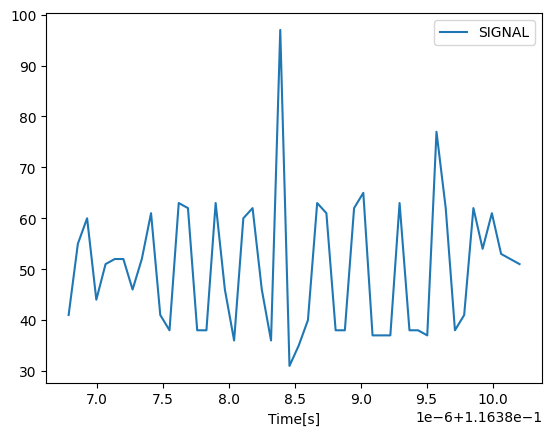

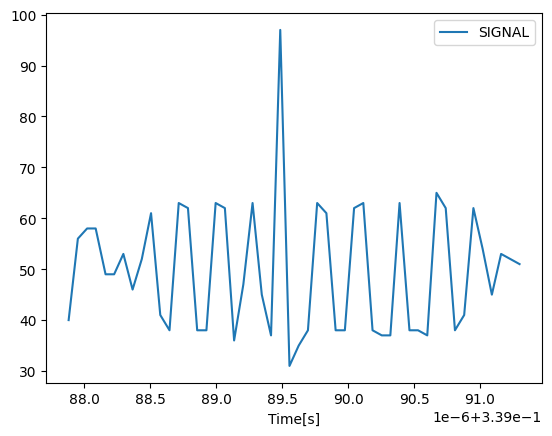

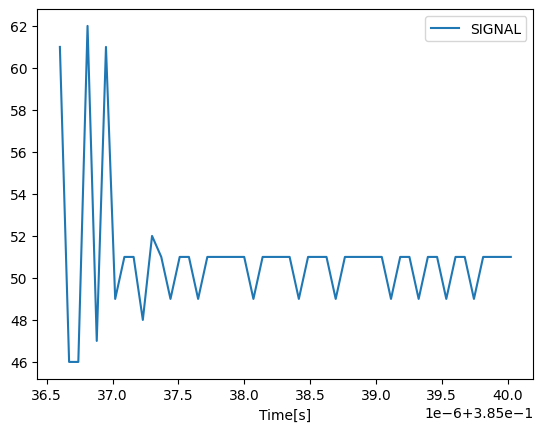

In [314]:
fieldsdf.loc[735463:736406].iloc[:50].plot(x='Time[s]', y='SIGNAL')
plt.show()
fieldsdf.loc[1666428:1667337].iloc[:50].plot(x='Time[s]', y='SIGNAL')
plt.show()
fieldsdf.loc[4855068:4855977].iloc[:50].plot(x='Time[s]', y='SIGNAL')
plt.show()
fieldsdf.loc[5512963:5513906].iloc[:50].plot(x='Time[s]', y='SIGNAL')
plt.show()

In [12]:
peaks, props
peak_nums = np.arange(len(peaks))
peak_freqs = frequencies[peaks]
peak_nums = peak_nums[(peak_freqs < 4e6) & (peak_freqs > 3e6)]
props


{'peak_heights': array([5.39868402])}

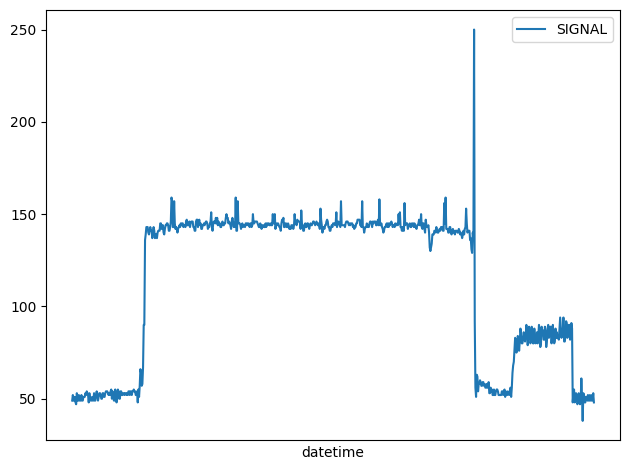

In [232]:
example_line = grouped.get_group(20)
fig,ax = plt.subplots()
# fig.set_size_inches(20,2)
# example_line.iloc[:50].plot(x='datetime', y='SIGNAL', ax=ax)
example_line.iloc[51:].iloc[:-70].plot(x='datetime', y='SIGNAL', ax=ax)
# example_line.plot(x='datetime', y='SIGNAL', ax=ax)
plt.tight_layout()
plt.show()

In [15]:
print('colorburst period:\n', (example_line.iloc[:50].datetime.max() - example_line.iloc[:50].datetime.min()).value/1000, 'us')
# calculate average frequency during cburst
sample_time_diffs = example_line.iloc[:50]['datetime'].diff().dropna()
sample_freqs = sample_time_diffs.apply(lambda x: 1/(x.value * 1e-9))
print(sample_freqs.mean())

sample_time_diffs = np.diff(example_line.iloc[:50]['datetime'].to_numpy())
1/(sample_time_diffs.astype(np.float64) * 1e-9)

colorburst period:
 3.42 us
14333557.598863723


array([14285714.28571429, 14285714.28571429, 14285714.28571429,
       14285714.28571429, 14285714.28571429, 14285714.28571429,
       14285714.28571429, 14285714.28571429, 14285714.28571429,
       14285714.28571429, 14285714.28571429, 14285714.28571429,
       14285714.28571429, 14285714.28571429, 15384615.38461538,
       14285714.28571429, 13333333.33333333, 15384615.38461538,
       14285714.28571429, 14285714.28571429, 14285714.28571429,
       14285714.28571429, 14285714.28571429, 14285714.28571429,
       14285714.28571429, 14285714.28571429, 14285714.28571429,
       14285714.28571429, 14285714.28571429, 14285714.28571429,
       14285714.28571429, 14285714.28571429, 14285714.28571429,
       14285714.28571429, 14285714.28571429, 14285714.28571429,
       14285714.28571429, 14285714.28571429, 14285714.28571429,
       14285714.28571429, 14285714.28571429, 14285714.28571429,
       14285714.28571429, 14285714.28571429, 14285714.28571429,
       14285714.28571429, 14285714.28571

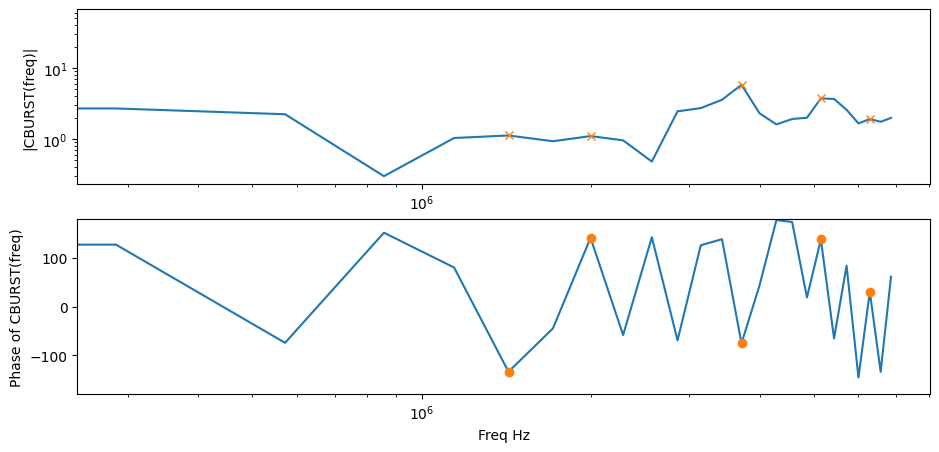

Colorburst Subcarrier Frequency: 3.714285718 MHz (3.58 MHz nominal)
Phase relative to start: -75.5782501420936 Degrees


In [16]:
colorburst = example_line.iloc[:50]['SIGNAL']
n = len(colorburst)
k = np.arange(n)
Fs = 14.2857143e6 # MHz, taken from !VID_CONV signal in original DF
T = n/Fs
frequencies = k/T

frequencies = frequencies[:len(frequencies)//2]
CBURST = np.fft.fft(colorburst)/n
CBURST = CBURST[:n//2]

peaks,props = signal.find_peaks(abs(CBURST), height=0)
frequencies[peaks]

# now let's plot the phase
phase = np.arctan2(np.imag(CBURST),np.real(CBURST))


fig, axs = plt.subplots(2,1,figsize=(11, 5))
axs[0].plot(frequencies, abs(CBURST))
axs[0].plot(frequencies[peaks], abs(CBURST[peaks]), 'x')
axs[0].set_xlabel('Freq Hz')
axs[0].set_ylabel('|CBURST(freq)|')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[1].plot(frequencies, phase*180/np.pi)
axs[1].plot(frequencies[peaks], phase[peaks]*180/np.pi, 'o')
axs[1].set_xlabel('Freq Hz')
axs[1].set_ylabel('Phase of CBURST(freq)')
axs[1].set_xscale('log')
axs[1].set_ybound((-180,180))
# axs[1].set_yscale('log')
plt.show()
scfrequency = frequencies[peaks[props['peak_heights'].argmax()]]
scphase = phase[peaks[props['peak_heights'].argmax()]]
print("Colorburst Subcarrier Frequency:", scfrequency/1e6, 'MHz', "(3.58 MHz nominal)")
print("Phase relative to start:", scphase*180/np.pi, 'Degrees')

In [17]:
x = abs(CBURST[peaks[props['peak_heights'].argmax()]])
x2 = colorburst[:30].max() - colorburst[:30].min()
h = abs(CBURST[0])
h2 = np.mean(colorburst)
print(x,x2,h,h2)

5.796972742069661 71 52.14 52.14


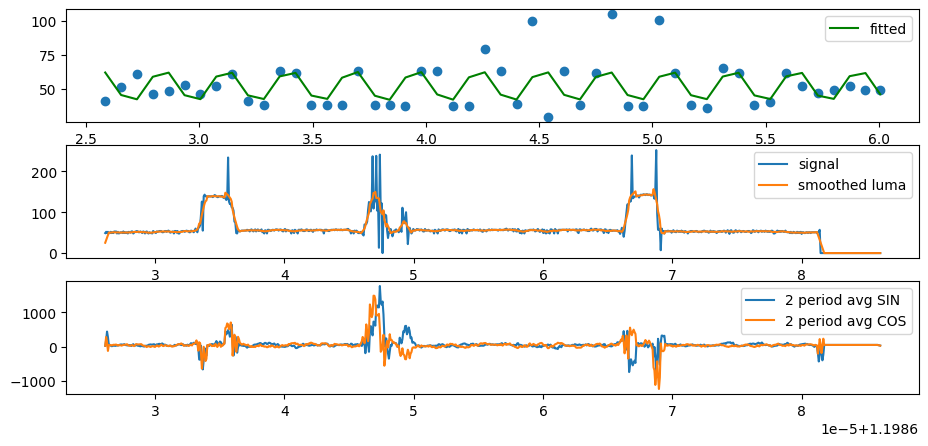

Guess Params: [7, 3579545.0, 0, 50]
Fitted Params: [11.944284959640452, 3579544.7665609824, 0.8980459954100479, 52.0852743427372]


In [42]:
from scipy.optimize import leastsq
# reconstructing the carrier from FFT
A = abs(CBURST[peaks[props['peak_heights'].argmax()]]) # amplitude
# t_est = np.linspace(0, (1/Fs) * len(colorburst), len(colorburst)) # time in seconds
t = example_line.iloc[:50]['datetime'].to_numpy().astype(np.float64) * 1e-9
# t_hires = np.linspace(t.min(), t.max(), 200)
carrier = A * np.sin(2 * np.pi * scfrequency * t + scphase) + abs(CBURST[0]) # adds dc offset from FFT
# carrier_hires = A * np.sin(2 * np.pi * scfrequency * t_hires + scphase) + abs(CBURST[0]) # adds dc offset from FFT
carrier_ideal = A * np.sin(2 * np.pi * 3.579545e6 * t + scphase) + abs(CBURST[0])

# reconstructing the carrier using least squares optimization and ideal parameters
# guess_params = [A, scfrequency, scphase, abs(CBURST[0])]
guess_params = [7, 3.579545e6, 0, 50]
optimize_func = lambda x: x[0]*np.sin(2*np.pi*x[1]*t + x[2]) + x[3] - colorburst
est_amp, est_freq, est_phase, est_mean = leastsq(optimize_func, guess_params)[0]
carrier_fit = est_amp * np.sin(2*np.pi*est_freq*t + est_phase) + est_mean

fig, axs = plt.subplots(3, 1, figsize=(11,5))
# example_line.iloc[:50].plot(y='SIGNAL', ax=axs[0])
axs[0].scatter(t,colorburst)
# axs[0].plot(t,carrier,'r', label='my guess')
axs[0].plot(t, carrier_fit, 'g', label='fitted')
axs[0].legend()
# axs[0].plot(t,carrier_ideal, 'g')

t = example_line.iloc[51:]['datetime'].to_numpy().astype(np.float64) * 1e-9
signal_after_cburst = example_line.iloc[51:]['SIGNAL'].to_numpy()
mul_sin = 4 * signal_after_cburst *  est_amp * np.sin(2*np.pi*est_freq*t + est_phase) + est_mean
samples_per_carrier_cycle = int(0.5 + Fs / est_freq)
avg_2period_sin = np.convolve(mul_sin, np.ones(2*samples_per_carrier_cycle), 'same') / (2*samples_per_carrier_cycle)

mul_cos = 4 * signal_after_cburst * est_amp * np.cos(2*np.pi*est_freq*t + est_phase) + est_mean
avg_2period_cos = np.convolve(mul_cos, np.ones(2*samples_per_carrier_cycle), 'same') / (2*samples_per_carrier_cycle)

luma = signal_after_cburst
luma_smooth = np.convolve(luma, np.ones(2*samples_per_carrier_cycle), 'same') / (2*samples_per_carrier_cycle)

axs[1].plot(t, signal_after_cburst, label='signal')
axs[1].plot(t, luma_smooth, label='smoothed luma')
axs[1].legend()
# axs[2].plot(t, mul, label='mul')
axs[2].plot(t, avg_2period_sin, label='2 period avg SIN')
axs[2].plot(t, avg_2period_cos, label='2 period avg COS')
axs[2].legend()
plt.show()
print("Guess Params:", guess_params)
print("Fitted Params:", [est_amp, est_freq, est_phase, est_mean])

In [33]:
# (1/est_freq) # s per cycle of the carrier
# (Fs) # samples per second
Fs * 1/est_freq

3.846152953394959

In [13]:
line_timedelta = example_line.datetime.max() - example_line.datetime.min()
line_timedelta

Timedelta('0 days 00:00:00.000063490')

In [23]:
print('Total period of one line:',line_timedelta.value / 1000, 'us')

Total period of one line: 63.49 us


In [592]:
lineinfodf = pd.DataFrame(line_info, columns=['period', 'lineno', 'startidx', 'endidx', 'scfreq', 'scphase'])
print(lineinfodf.dtypes)
# print(lineinfodf.loc[lineinfodf['period'] < pd.Timedelta(0.000063, 's')])
print(lineinfodf['period'].describe())
print(lineinfodf[['scfreq']].dropna().astype('float64').describe())
print(lineinfodf[['scphase']].dropna().astype('float64').describe())

period      timedelta64[ns]
lineno                int64
startidx              int64
endidx                int64
scfreq               object
scphase              object
dtype: object
count                        18288
mean     0 days 00:00:00.000064487
std      0 days 00:00:00.000025503
min      0 days 00:00:00.000002160
25%      0 days 00:00:00.000063485
50%      0 days 00:00:00.000063485
75%      0 days 00:00:00.000063490
max      0 days 00:00:00.000635425
Name: period, dtype: object
             scfreq
count  1.821600e+04
mean   3.579680e+06
std    7.179352e+02
min    3.579546e+06
25%    3.579547e+06
50%    3.579551e+06
75%    3.579569e+06
max    3.590212e+06
            scphase
count  18216.000000
mean     -55.498874
std      106.362259
min    -1229.372947
25%      -47.741768
50%      -23.566149
75%      -15.184662
max       -5.687068


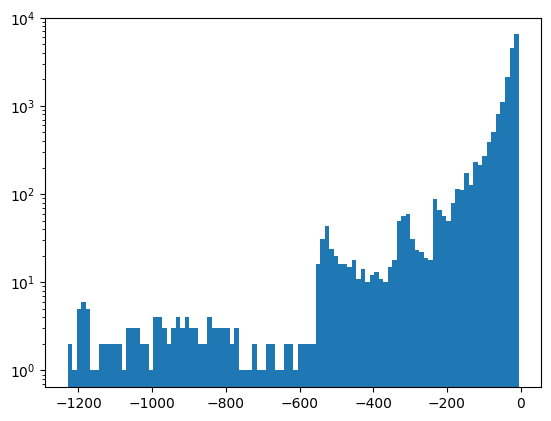

In [593]:
plt.hist(lineinfodf['scphase'].dropna().astype('Float64'),bins=100)
plt.yscale('log')
plt.show()

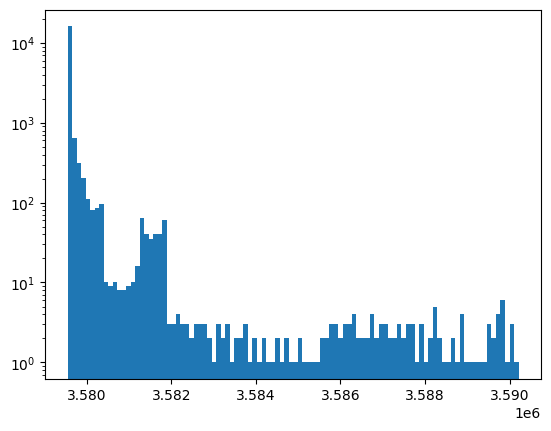

In [594]:
plt.hist(lineinfodf['scfreq'].dropna().astype('float64'),bins=100)
plt.yscale('log')
plt.show()

In [193]:
print(lineinfodf.dropna().iloc[lineinfodf['scfreq'].dropna().astype('float64').argmax()])
print(lineinfodf.dropna().iloc[lineinfodf['scfreq'].dropna().astype('float64').argmin()])

period      0 days 00:00:00.000063485
lineno                            187
startidx                      2160491
endidx                        2638240
scfreq                    6571428.578
Name: 2219, dtype: object
period      0 days 00:00:00.000065860
lineno                              1
startidx                     11237741
endidx                       11715490
scfreq                    1142857.144
Name: 11685, dtype: object


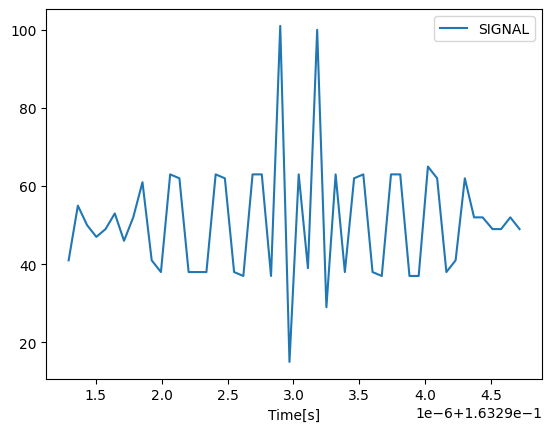

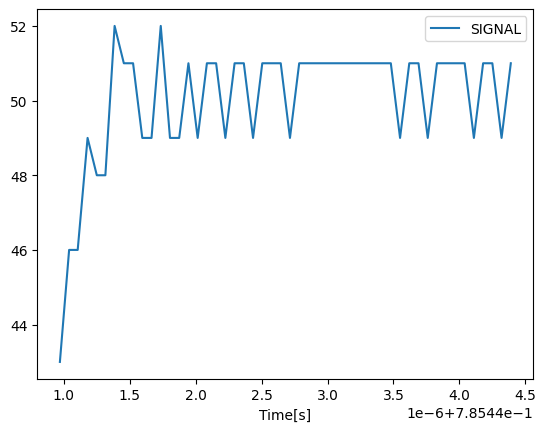

In [198]:
highest_cburst = fieldsdf.loc[2160491:2638240]
highest_cburst = highest_cburst.loc[(highest_cburst['STATE'] == 'even_field') | (highest_cburst['STATE'] == 'odd_field')]
highest_cburst = highest_cburst.loc[(highest_cburst[' VID_BLK'].diff() < 0).cumsum() == 187]
highest_cburst.iloc[:50].plot(x='Time[s]', y='SIGNAL')
plt.show()

lowest_cburst = fieldsdf.loc[11237741:11715490]
lowest_cburst = lowest_cburst.loc[(lowest_cburst['STATE'] == 'even_field') | (lowest_cburst['STATE'] == 'odd_field')]
lowest_cburst = lowest_cburst.loc[(lowest_cburst[' VID_BLK'].diff() < 0).cumsum() == 1]
lowest_cburst.iloc[:50].plot(x='Time[s]', y='SIGNAL')
plt.show()

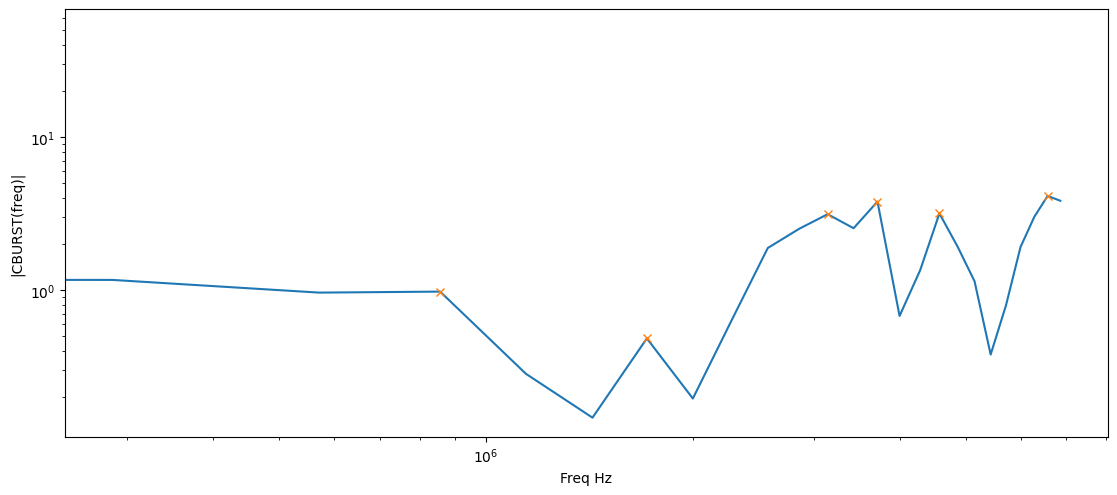

Colorburst Subcarrier Frequency: 6.571428578000001 MHz (3.58 MHz nominal)
{'peak_heights': array([0.97765232, 0.48386408, 3.13077493, 3.78386453, 3.16565196,
       4.11964539])}


In [192]:
colorburst = highest_cburst.iloc[:50]['SIGNAL']
n = len(colorburst)
k = np.arange(n)
Fs = 14.2857143e6 # MHz, taken from !VID_CONV signal in original DF
T = n/Fs
frequencies = k/T

frequencies = frequencies[:len(frequencies)//2]
CBURST = np.fft.fft(colorburst)/n
CBURST = CBURST[:n//2]

peaks,props = signal.find_peaks(abs(CBURST), height=0)
frequencies[peaks]

fig, ax = plt.subplots(figsize=(11, 5))
ax.plot(frequencies, abs(CBURST))
ax.plot(frequencies[peaks], abs(CBURST[peaks]), 'x')
plt.tight_layout()
plt.xlabel('Freq Hz')
plt.ylabel('|CBURST(freq)|')
plt.xscale('log')
plt.yscale('log')
plt.show()

print("Colorburst Subcarrier Frequency:", frequencies[peaks[props['peak_heights'].argmax()]]/1e6, 'MHz', "(3.58 MHz nominal)")
print(props)

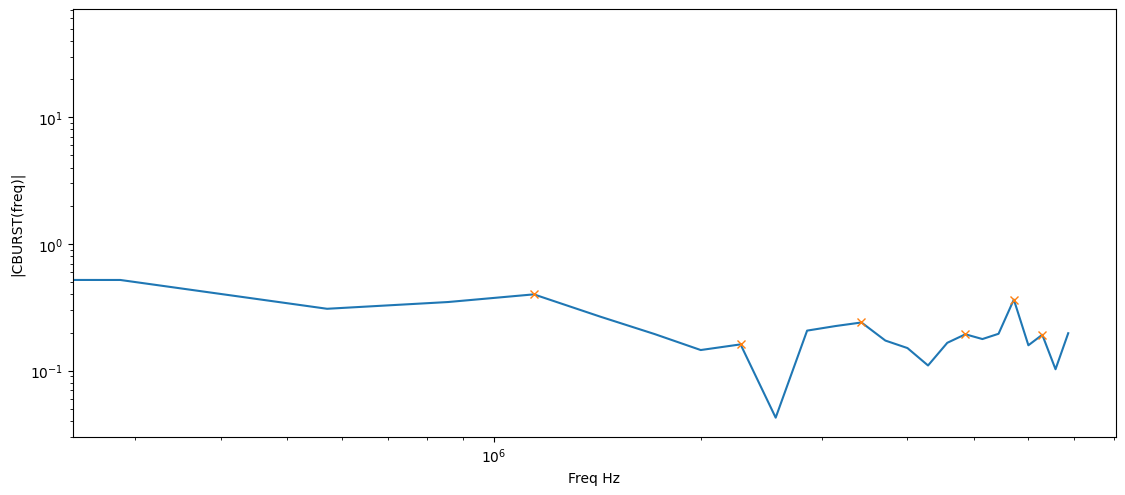

Colorburst Subcarrier Frequency: 1.1428571440000002 MHz (3.58 MHz nominal)
{'peak_heights': array([0.40004304, 0.16126015, 0.24006189, 0.19375179, 0.36376003,
       0.19206978])}


In [199]:
colorburst = lowest_cburst.iloc[:50]['SIGNAL']
n = len(colorburst)
k = np.arange(n)
Fs = 14.2857143e6 # MHz, taken from !VID_CONV signal in original DF
T = n/Fs
frequencies = k/T

frequencies = frequencies[:len(frequencies)//2]
CBURST = np.fft.fft(colorburst)/n
CBURST = CBURST[:n//2]

peaks,props = signal.find_peaks(abs(CBURST), height=0)
frequencies[peaks]

fig, ax = plt.subplots(figsize=(11, 5))
ax.plot(frequencies, abs(CBURST))
ax.plot(frequencies[peaks], abs(CBURST[peaks]), 'x')
plt.tight_layout()
plt.xlabel('Freq Hz')
plt.ylabel('|CBURST(freq)|')
plt.xscale('log')
plt.yscale('log')
plt.show()

print("Colorburst Subcarrier Frequency:", frequencies[peaks[props['peak_heights'].argmax()]]/1e6, 'MHz', "(3.58 MHz nominal)")
print(props)

In [260]:
frames_arr.shape

(36, 525, 910)

In [587]:
frames_arr[6].mean()

63.47937205651491

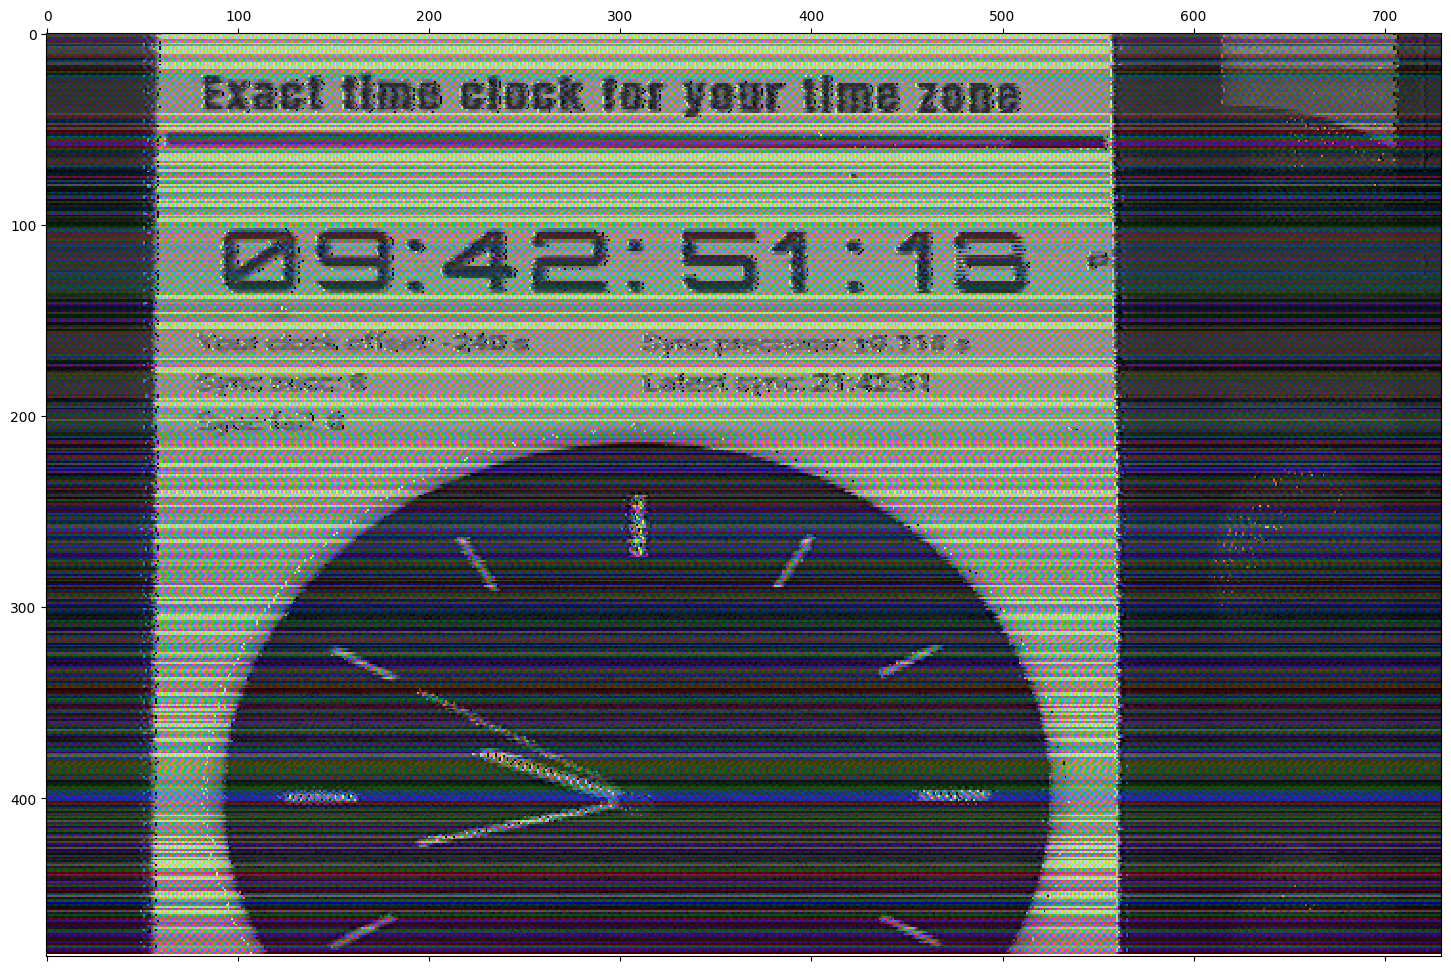

In [618]:
fig, ax = plt.subplots()
fig.set_size_inches(18,16)
# ax.matshow(frames_arr[0,23:506,:790], cmap='Greys_r') # bw only
# ax.matshow(frames_arr[0], cmap='Greys_r') # bw only
# ax.imshow(frames_arr[2, 23:506, :780, :])
# ax.imshow(np.mean(frames_arr[6, 23:506, :780, :], axis=2), cmap='Greys_r')
ax.matshow(frames_arr[6, croptop:cropbottom, cropleft:cropright, :])
plt.show()

In [562]:
# RGB.min(), RGB.max(), RGB.mean()
np.quantile(RGB, [0,.1,.5,.95,1])

array([-0.51584013, -0.13813152,  0.01020206,  0.69719186,  1.88996169])

In [297]:
np.save('frames_arr.npy', frames_arr)

In [2]:
frames_arr_file = np.load('frames_arr.npy')
n_frames = frames_arr_file.shape[0]
frames_arr = frames_arr_file

In [203]:
plt.get_backend()

'module://matplotlib_inline.backend_inline'

In [619]:
prev_backend = 'module://matplotlib_inline.backend_inline'
plt.switch_backend('TkAgg')
%matplotlib tk
fig,ax = plt.subplots()
ims = []
for i in range(n_frames):
    im = ax.imshow(frames_arr[i], animated=True)
    # if i == 0:
    #     ax.matshow(frames_arr[i], cmap='Greys_r') # show initial frame
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=int(2/60 * 1000,), blit=True, repeat_delay=0)
fig.show()
print('done')


done


In [620]:
plt.switch_backend(prev_backend)
%matplotlib inline

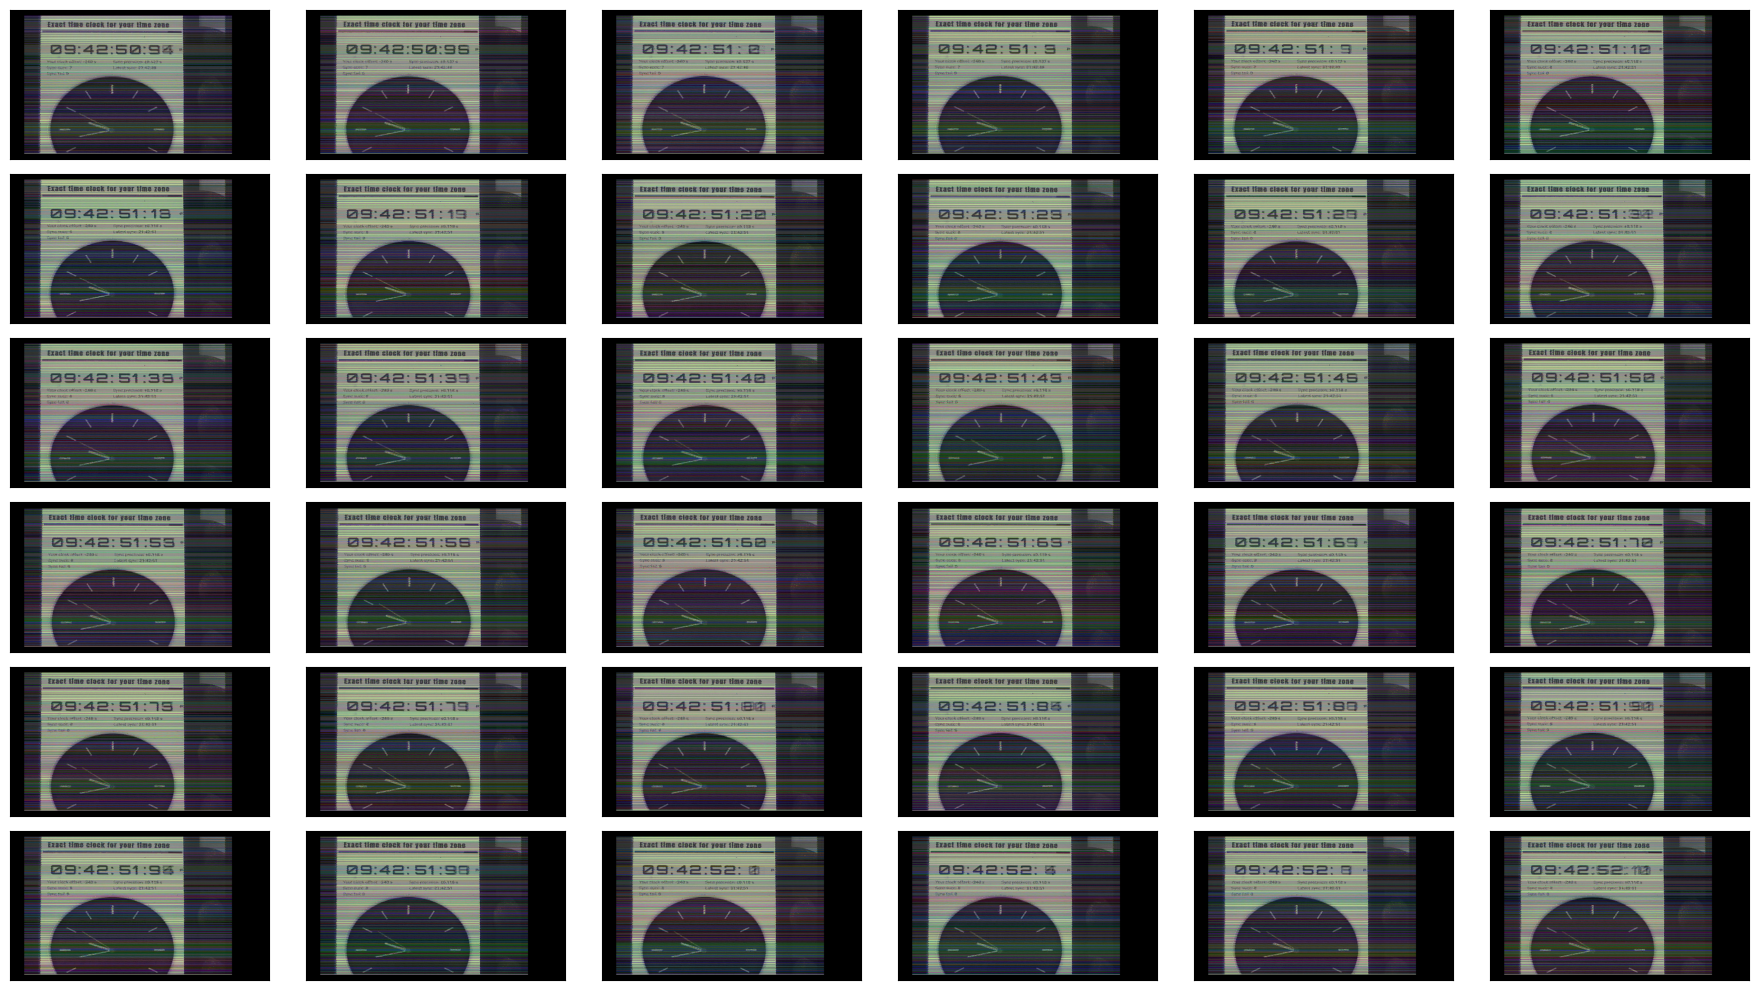

In [616]:
fig,axs = plt.subplots(nrows=6,ncols=6,figsize=(18,10))
i=0
for im in frames_arr:
    fig.axes[i].imshow(im,cmap='Greys_r', )
    fig.axes[i].set_xticks([])
    fig.axes[i].set_yticks([])
    i+=1
while i < len(fig.axes):
    fig.axes[i].imshow([[0],[0]])
    fig.axes[i].set_xticks([])
    fig.axes[i].set_yticks([])
    i+=1
plt.tight_layout()
plt.show()